<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classficiation-CNN/CNN_to_Classification(with_ResNet50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries & Set Paths

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set parameters and paths
SPLIT_DATASET_PATH = '/content/drive/MyDrive/DSGP/Splitted_Dataset'
MODEL_SAVE_PATH = '/content/drive/MyDrive/DSGP/resnet_model.keras'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 50

Create Data Generators

In [3]:
def load_datasets(split_dataset_path, batch_size, img_size):
    TRAIN_DIR = os.path.join(split_dataset_path, 'train')
    VAL_DIR   = os.path.join(split_dataset_path, 'val')
    TEST_DIR  = os.path.join(split_dataset_path, 'test')

    # Load raw training dataset to capture class names
    raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR,
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        color_mode='rgb'
    )
    class_names = raw_train_dataset.class_names
    print("Classes:", class_names)

    # Load raw validation and test datasets
    raw_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        VAL_DIR,
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        color_mode='rgb'
    )
    raw_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR,
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        color_mode='rgb',
        shuffle=False  # Keep order for evaluation
    )

    # Optimize dataset pipeline with caching and prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = raw_train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    val_dataset = raw_val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    test_dataset = raw_test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    return train_dataset, val_dataset, test_dataset, class_names

Build & Compile the CNN Model

In [4]:
def build_resnet_model(img_size, num_classes, fine_tune=False):
    # Load ResNet50 as the base model with pretrained ImageNet weights, exclude top layers
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))
    base_model.trainable = False  # Freeze base model initially

    # Build custom classification head with data augmentation layers
    inputs = Input(shape=(img_size[0], img_size[1], 3))
    # Data augmentation: Randomly flip and rotate images to improve generalization
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)
    # Preprocess input for ResNet50
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    if fine_tune:
        base_model.trainable = True
        # Freeze all layers except the top 20 layers of the base model
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        print("Base model partially unfrozen for fine-tuning.")
    return model

Train & Save the Model

In [5]:
def train_model(model, train_dataset, val_dataset, epochs):
    # Add callbacks for early stopping and reducing learning rate on plateau
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )
    return history

def save_model_keras(model, model_save_path):
    model.save(model_save_path)
    print("Model saved successfully at:", model_save_path)

Plot Training History

In [6]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

Evaluate the Model

In [7]:
def evaluate_model(model, test_dataset, class_names):
    predictions = model.predict(test_dataset, verbose=1)
    predicted_labels = np.argmax(predictions, axis=1)

    # Extract true labels from the test dataset
    true_labels = []
    for images, labels in test_dataset:
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
    true_labels = np.array(true_labels)

    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Main Execution

Found 25600 files belonging to 16 classes.
Classes: ['astrocitoma', 'carcinoma', 'ependimoma', 'ganglioglioma', 'germinoma', 'glioblastoma', 'granuloma', 'meduloblastoma', 'meningioma', 'neurocitoma', 'no_tumour', 'oligodendroglioma', 'papiloma', 'pituitary', 'schwannoma', 'tuberculoma']
Found 3200 files belonging to 16 classes.
Found 3200 files belonging to 16 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip (RandomFlip)  │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation           │ (None, 224, 224, 3)    │              0 │ random_flip[0][0]      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ random_rotation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ random_rotation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ random_rotation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         32,784 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,620,496 (90.11 MB)

 Trainable params: 32,784 (128.06 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1772s 2s/step - accuracy: 0.4473 - loss: 1.9471 - val_accuracy: 0.7416 - val_loss: 0.8549 - learning_rate: 0.0010
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7127 - loss: 0.9080 - val_accuracy: 0.7812 - val_loss: 0.7134 - learning_rate: 0.0010
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.7526 - loss: 0.7756 - val_accuracy: 0.7991 - val_loss: 0.6739 - learning_rate: 0.0010
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.7665 - loss: 0.7433 - val_accuracy: 0.8159 - val_loss: 0.5979 - learning_rate: 0.0010
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.7715 - loss: 0.7115 - val_accuracy: 0.8144 - val_loss: 0.6101 - learning_rate: 0.0010
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.7759 - loss: 0.7108 - val_accuracy: 0.8116 - val_loss: 0.5953 - learning_rate: 0.0010
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.7801 - l

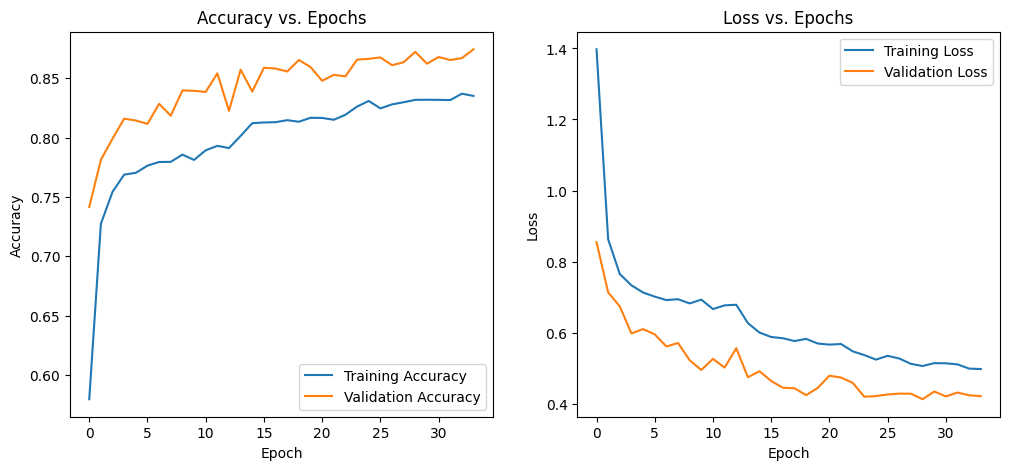

100/100 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step
Classification Report:
                   precision    recall  f1-score   support

      astrocitoma       0.77      0.68      0.72       200
        carcinoma       0.99      0.83      0.91       200
       ependimoma       0.90      0.85      0.88       200
    ganglioglioma       0.94      0.99      0.97       200
        germinoma       0.86      0.94      0.90       200
     glioblastoma       0.90      0.84      0.87       200
        granuloma       0.85      0.94      0.89       200
   meduloblastoma       0.78      0.95      0.86       200
       meningioma       0.94      0.83      0.88       200
      neurocitoma       0.82      0.89      0.85       200
        no_tumour       0.89      0.97      0.93       200
oligodendroglioma       0.95      0.83      0.89       200
         papiloma       0.92      0.83      0.87       200
        pituitary       0.84      0.97      0.90       200
       schwannoma       0.78      0.81      0.79 

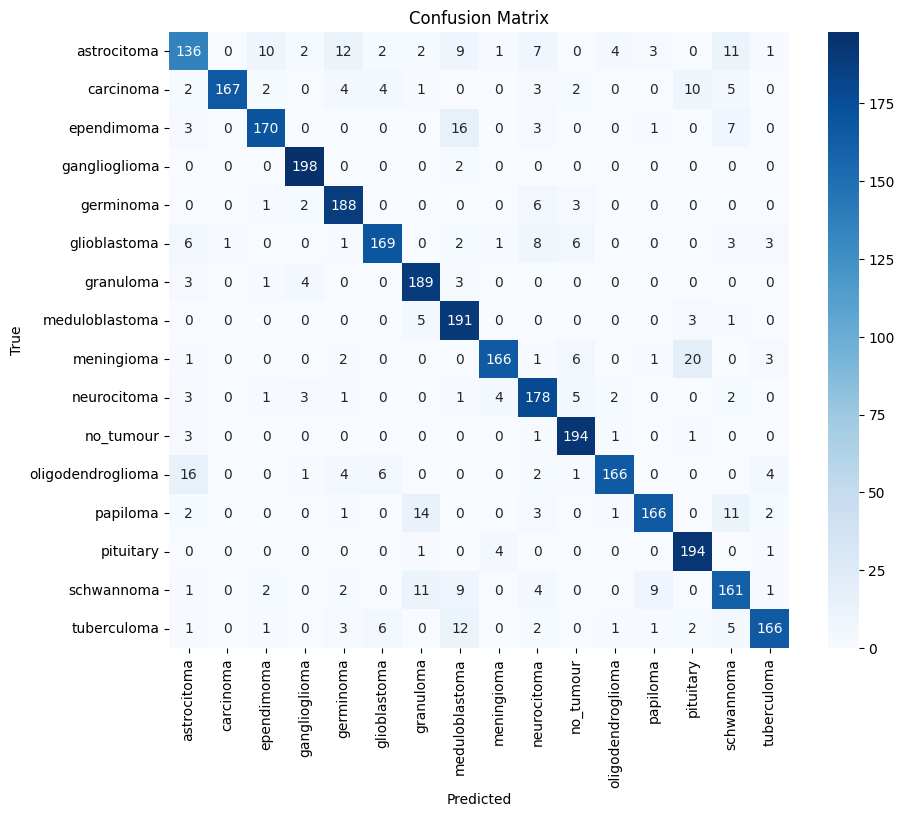

In [8]:
if __name__ == '__main__':
    # Load datasets and class names
    train_dataset, val_dataset, test_dataset, class_names = load_datasets(SPLIT_DATASET_PATH, BATCH_SIZE, IMG_SIZE)
    num_classes = len(class_names)

    # Build the ResNet model; set fine_tune=True to unfreeze top layers after initial training if desired
    model = build_resnet_model(IMG_SIZE, num_classes, fine_tune=False)

    # Train the model with callbacks
    history = train_model(model, train_dataset, val_dataset, EPOCHS)

    # Save the model in Keras (SavedModel) format
    save_model_keras(model, MODEL_SAVE_PATH)

    # Plot training history
    plot_training_history(history)

    # Evaluate the model on the test dataset
    evaluate_model(model, test_dataset, class_names)

Test with some Example Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


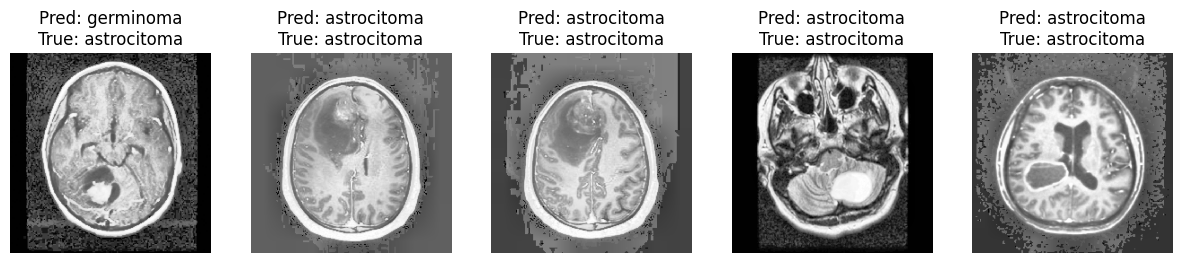

In [9]:
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels.numpy(), axis=1)

    num_images_to_show = 5
    plt.figure(figsize=(15, 3))
    for i in range(num_images_to_show):
        ax = plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        pred_class = class_names[predicted_labels[i]]
        true_class = class_names[true_labels[i]]

        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis("off")
    plt.show()

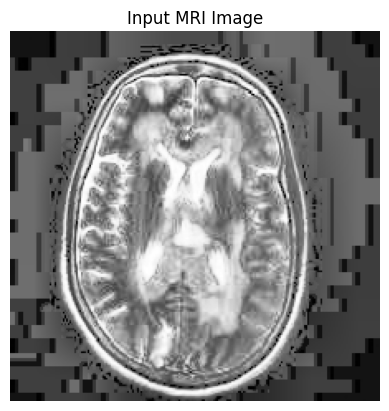

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted class: no_tumour


In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Path to your MRI image file (update this path as needed)
mri_image_path = '/content/drive/MyDrive/DSGP/Splitted_Dataset/test/no_tumour/image_1018.png'

# Load the image with the target size of 224x224
img = load_img(mri_image_path, target_size=(224, 224))
# Convert the image to a numpy array (values remain in [0, 255])
img_array = img_to_array(img)
# Expand dimensions to create a batch of size 1
img_array = np.expand_dims(img_array, axis=0)

# Display the image
plt.imshow(img)
plt.title("Input MRI Image")
plt.axis("off")
plt.show()

# Get predictions from the model (model should handle normalization internally)
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class = class_names[predicted_class_index]

print("Predicted class:", predicted_class)
